In [1]:
import os
import re
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import unicodecsv as csv
import seaborn as sns
from collections import Counter
from cycler import cycler
from textwrap import wrap
from IPython.display import display, HTML, Markdown

In [2]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

In [3]:
from time import time
from IPython import get_ipython
import winsound

class Beeper:

    def __init__(self, threshold):
        self.threshold = threshold
        self.start_time = None    # time in sec, or None

    def pre_execute(self):
        if not self.start_time:
            self.start_time = time()

    def post_execute(self):
        end_time = time()
        if self.start_time and end_time - self.start_time > self.threshold:
            winsound.Beep(2500,1000)
        self.start_time = None


beeper = Beeper(60)

ipython = get_ipython()
ipython.events.register('pre_execute', beeper.pre_execute)
ipython.events.register('post_execute', beeper.post_execute)

In [4]:
%%html
<style>
div.float-bar-whh {
    z-index: 10;
    position: fixed;
    bottom: 5px;
    width: 540px;
    left: 50%;
    right: 50%;
    padding-right: 0px;
    padding-left: 0px;
    margin-left: -270px;
    background: #333;
    opacity: 0.7;
    box-shadow: 0 0 2px 0px black;
}
span.new-name-whh {
    height: 100%;
    line-height: 1em;
    margin: 16px 16px 16px 16px;
    border: none;
    font-size: 146.5%;
    color: white;
    text-overflow: ellipsis;
    overflow: hidden;
    white-space: nowrap;
    border-radius: 2px;
    opacity: 1;
}
</style>

<div class="float-bar-whh" style="display:block;">
    <center><span class="new-name-whh">Finance</span></center>
</div>

# Analysize variables.

In [5]:
# Read documentation.
columns_file = r"../records_documentation.txt"

with open(columns_file,"r") as f:
    columns = f.readlines()
columns
        

['[Column 0] ID\n',
 '[Column 1] Birth year: deduced from education history, where available\n',
 '[Column 2] Gender flag: 1=female, 2=male, 0=unknown\n',
 '[Column 3] Skillset1: primary skillset deduced from self-reported skills\n',
 '[Column 4] Skillset1 weight: the extent to which primary skillset is representative of overall self-reported skills\n',
 '[Column 5] Skillset2: secondary skillset deduced from self-reported skills\n',
 '[Column 6] Skillset2 weight: the extent to which secondary skillset is representative of overall self-reported skills\n',
 '[Column 7] City of profile (does not change): where unavailable, the field is left blank\n',
 '[Column 8] Country of Profile (does not change)\n',
 '[Column 9] Education (highest degree attained): 0=none/unknown; 1=high school; 2=vocational degree; 3=associateÕs; 4=bachelorÕs; 5=masterÕs other than MBA; 6=MBA; 7=doctorate (PhD/JD/MD) [NB: Romanian names not covered]\n',
 "[Column 10] Elite institution: a flag indicating whether any o

So:
- Unique identifier: ID.
- Variable Groups:
    - Column 0-10, profile info; 
    - Column 11-28, employment or education info; (c26 = False or True)
        - Column 11-18, general info;
        - Column 19-25, company info;
        - Column 27-28, school info.

In [6]:
# Define an iterator for reading rows.
def rows_iter(index=True):
    if index:
        for index, line in enumerate(rows_iter(index=False)):
             yield index, line
    else:
        empl_file = r"../fin/finance_profiles.csv"
        with open(empl_file,"rb") as f:
            reader = csv.reader(f,encoding='utf-8',escapechar='',delimiter='\t')
            for line in reader:
                del line[1]
                yield line

In [7]:
# # Get unique values for each variable.
# unique_values = []
# for i in range(33):
#     unique_values.append(set())
# # Get unique values for each variable.
# for idx, line in rows_iter():
#     for i in range(33):
#         unique_values[i].add(line[i])
# for idx, values in enumerate(unique_values):
#     print("[Column {}] ".format(idx)+str(len(values)))

In [8]:
# # Get unique values for "ticker-naics-ticcode" tuple.
# unique_tuples = set()
# for idx, line in rows_iter():
#     if idx == -1:
#         break
#     unique_tuples.add((line[21], line[25], line[31])) 

In [9]:
# ticker_dict = {}
# for ticker, naics, ticcode in unique_tuples:
#     if ticcode in ticker_dict:
#         ticker_dict[ticcode] += [(ticker, naics)]
#     else:
#         ticker_dict[ticcode] = [(ticker, naics)]
# ticker_dict

In [10]:
# One block to convert data to pd.DataFrame.
entries_lst = []
for idx, line in rows_iter():
    if idx == 100: # Control number of rows.
        break
    entries_lst.append(line)

samples_lst = entries_lst
entries_df = pd.DataFrame(data=entries_lst)

entries_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
0,f035a384-cd3c-3185-8340-c0ac1459d9ae,2001,1,-1,0,-1,0,Bronx,United States,0,False,None,False,None,False,True,,finacial associate,,citi,citi,C,XNYS,True,,522291,False,,False,,,BBG000FY4S11,1503620559000
1,5ad24f8c-72d7-34b8-87c4-74ee992f0d50,1970,1,-1,0,-1,0,Milan,Italy,4,False,1988-01-01,False,1993-01-01,False,False,1827,"""Laurea, Discipline Economico-Sociali (DES)"",Laurea,Discipline Economico-Sociali,DES",,Università Bocconi,Università Bocconi,UNIVERSITY,ITALY,False,,,True,4,False,,,,1530808751000
2,5ad24f8c-72d7-34b8-87c4-74ee992f0d50,1970,1,-1,0,-1,0,Milan,Italy,4,False,1993-01-01,False,1995-02-01,True,False,761,,,TIME_OFF,TIME_OFF,TIME_OFF,OTHER,False,Italy,TIME_OFF,False,,False,,,,1530808751000
3,5ad24f8c-72d7-34b8-87c4-74ee992f0d50,1970,1,-1,0,-1,0,Milan,Italy,4,False,1995-03-01,True,2005-08-01,True,False,3806,"Sales Support Assicurazioni & Riassicurazioni,sales support",MARKETING,Europ Assistance Italia,europ assistance,,ITALY,False,,52,False,,False,,,,1530808751000
4,5ad24f8c-72d7-34b8-87c4-74ee992f0d50,1970,1,-1,0,-1,0,Milan,Italy,4,False,2005-09-01,True,2013-12-01,True,False,3013,"Responsabile Assicurazioni; Banche e Mercato Finanziario,responsabile",,Mondial Assistance Italia,Mondial Assistance Italia,,,False,,,False,,False,,,,1530808751000
5,5ad24f8c-72d7-34b8-87c4-74ee992f0d50,1970,1,-1,0,-1,0,Milan,Italy,4,False,2014-01-01,True,None,False,True,1834,"National Account Manager Allianz Group Italy,account manager",,Allianz Worldwide Partners,Allianz Worldwide Partners,,,False,"milan area, italy",,False,,False,,,,1530808751000
6,947afa64-5369-3825-9d43-3a2ee7a44e89,1972,0,-1,0,-1,0,Brooklyn,United States,4,False,2001-01-01,True,2006-07-01,True,False,2007,"Regional Account Executive,account executive",,MCI Corporation,mci,,UNITED STATES,False,,51,False,,False,,,,1518862557000
7,947afa64-5369-3825-9d43-3a2ee7a44e89,1972,0,-1,0,-1,0,Brooklyn,United States,4,False,2006-09-01,True,2007-04-01,True,False,212,"Regional Account Manager,account manager",,Washington Mutual Card Services,washington mutual,,UNITED STATES,False,,52,False,,False,,,,1518862557000
8,947afa64-5369-3825-9d43-3a2ee7a44e89,1972,0,-1,0,-1,0,Brooklyn,United States,4,False,2007-03-01,True,None,False,True,4332,"Student Teacher,student,teacher",,NYC Board of Education,nyc board of,,UNITED STATES,False,,61,False,,False,,,,1518862557000
9,947afa64-5369-3825-9d43-3a2ee7a44e89,1972,0,-1,0,-1,0,Brooklyn,United States,4,False,2008-01-01,False,2014-01-01,False,False,2192,""""""" Bachelor of Science """" BA, Special Education and Teaching"","""""" Bachelor of Science """" BA"",Special Education and Teaching",,Touro College,Touro College,UNIVERSITY,UNITED STATES,False,,,True,4,False,,,,1518862557000


In [11]:
# Get an example.
entry = samples_lst[13]
for i in range(len(entry)):
    print("[Column {}] ".format(i),entry[i])

[Column 0]  f6e5ddfa-3c7a-3139-88c1-3015a1f4ce9d
[Column 1]  1978
[Column 2]  1
[Column 3]  -1
[Column 4]  0
[Column 5]  -1
[Column 6]  0
[Column 7]  Geneva
[Column 8]  Switzerland
[Column 9]  5
[Column 10]  False
[Column 11]  2008-06-01
[Column 12]  True
[Column 13]  2008-08-01
[Column 14]  True
[Column 15]  False
[Column 16]  61
[Column 17]  Operations Summer Analyst,operations,analyst
[Column 18]  OPERATIONS
[Column 19]  Goldman Sachs
[Column 20]  Goldman Sachs
[Column 21]  GS
[Column 22]  XNYS
[Column 23]  True
[Column 24]  new york / new jersey, united states
[Column 25]  523110
[Column 26]  False
[Column 27]  
[Column 28]  False
[Column 29]  
[Column 30]  
[Column 31]  BBG000C6CFJ5
[Column 32]  1531074992000


# Aggregate employment changes to the firm-by-date level.

Definition of employment change types: When only employment records are considered, an employment change will be recognized as
- `hiring` if it changed its company to one of the companies (listed [here](#company_lst));
- `firing` if it changed its company from one of the companies to `TIME_OFF` and stayed in `TIME_OFF` for more than 100 days;
- `leaving` if it changed its company from one of the companies and not recogized as `firing`.

In [12]:
# Define a class to read and process entries.
class entryProcessor:    
    
    def __init__(self, person_id):
        self.person_id = person_id
        self.profile = [None]*7 # "birth_year","gender","skill1","skill2","country","education_level","f_elite"
        self.employment = [None]*7 # "start_date","end_date","ticker","f_current","job_role","department", "nth_posit"
        self.company = [None]*2 # "nconame", "naics" 
        
    # Three functions to output records.
    # Varlist: Hiring/Leaving/Firing, Ticker, year-month, profile_info: [...], next_industry.
    def enter_record(self):
        return ['hiring',self.employment[2],self.employment[0]
               ]+self.profile+[self.employment[4],self.employment[5]
                              ]+['']+['','']+self.company
    def leave_record(self,next_industry):
        return ['leaving',self.employment[2],self.employment[1]
               ]+self.profile+[self.employment[4],self.employment[5]
                              ]+[next_industry]+[entryProcessor.time_diff(self.employment[1],self.employment[0]),
                                                 self.employment[6]]+self.company
    def fired_record(self):
        return ['firing',self.employment[2],self.employment[1]
               ]+self.profile+[self.employment[4],self.employment[5]
                              ]+['']+[entryProcessor.time_diff(self.employment[1],self.employment[0]),
                                      self.employment[6]]+self.company
    
    # When id changes, record a possible leave and then clear contents.
    def reinitialize(self,entry):
        if self.employment[3]=="False":
            record = self.leave_record('')
        else:
            record = None
        self.__init__(entry[0])
        self.profile = [entry[x] for x in [1,2,3,5,8,9,10]]
        if entry[6] is not None:
            self.profile[3] = '' if float(entry[6])<0.1 else entry[5]
        return record
    
    # Main method: read and process.
    def read(self,entry):
        record = []
        # Reinitialize when id changes.
        if self.person_id != entry[0]:
            leave_last = self.reinitialize(entry)
            if leave_last is not None:
                record.append(leave_last)
        # Then deal with the current entry.
        if entry[3] != "-1" and entry[26] == "False" and not sum([
            re.search(r"(?i)\W{}\W".format(x)," "+entry[17]+" ") is not None 
            for x in ["intern","internship","trainee","student","summer"]
        ]):
            if self.company[0] != entry[20]:
                if entryProcessor.is_fin(self.company[1]):
                    if entry[25] == "TIME_OFF" and int(entry[16]) > 100:
                        record.append(self.fired_record())
                    else:
                        record.append(self.leave_record(entry[25]))
                self.employment = [None]*7
                self.company = [None]*2
                if entryProcessor.is_fin(entry[25]):
                    self.employment[0] = entryProcessor.convert_time(entry[11],entry[12])
                    self.employment[1] = entryProcessor.convert_time(entry[13],entry[14])
                    self.employment[2] = entry[21]+"@"+entry[22] if entry[21]!="" else ""
                    self.employment[3] = entry[15]
                    self.employment[4] = entry[17]
                    self.employment[5] = entry[18]
                    self.employment[6] = 0
                    self.company = [entry[20],entry[25]]
                    record.append(self.enter_record())
            else:
                self.employment[1] = entryProcessor.convert_time(entry[13],entry[14])
                self.employment[3] = entry[15]
                self.employment[6] += 1
        return record
            
    # Unbound methods.
    def convert_time(date,f_valid_month):
        date_regex = re.match(r"(\d{4})-(\d{2})-\d{2}",date)
        if date_regex is None:
            return None
            #raise ValueError('Not a proper date: {}'.format(date))
        else:
            return date_regex.group(1)+('00' if f_valid_month == 'False' else date_regex.group(2))
    
    def time_diff(end_date,start_date):
        if end_date is not None and start_date is not None:
            edt, sdt = int(end_date), int(start_date)
            yr_diff = edt//100-sdt//100
            emth = edt%100
            smth = sdt%100
            if not yr_diff and not (emth and smth):
                return min(6,(emth-smth-1)%12+1)
            else:
                return yr_diff*12+(emth if emth else 6)-(smth if smth else 6)
        else:
            return np.nan
    
    def is_fin(naics):
        return naics is not None and len(naics)>=2 and naics[:2]=='52'
        
    # For print.
    def __str__(self):
        return "[person_id: {}, profile: {}, employment: {}]".format(self.person_id, self.profile, self.employment)
            
#entry = entryProcessor(None)
#for i in range(50):
#    print(i)
#    print(entry.read(samples_lst[i]))
#    print(entry)

In [13]:
# Read, Identify & Aggregate.

## Initialize.
career = entryProcessor(None)

## Iterate.
empl_changes_lst = []
for idx, entry in itertools.chain(rows_iter(),[(None,[None]*40)]):
    if idx == -1: # End point.
        break
    empl_changes_lst += career.read(entry)

varlist = [
    "type","ticker","yrmth","birth","gender","skill1","skill2","cntry","edu","f_elite",
    "job_role","depmt","ind_next","tenure","nprom","nconame","naics"
]
empl_changes_df = pd.DataFrame(data=empl_changes_lst,columns=varlist)
empl_changes_df["ticker"] = "All"
empl_changes_df


,type,ticker,yrmth,birth,gender,skill1,skill2,cntry,edu,f_elite,job_role,depmt,ind_next,tenure,nprom,nconame,naics
0,hiring,All,201611,1992,2,Hospitality,,United Arab Emirates,4,False,"Food And Beverage Attendant,food and beverage,attendant",OPERATIONS,,,,Fairmont Hotels & Resorts,523
1,hiring,All,201404,1979,0,Hospitality,,Vietnam,0,False,Jr.Sous chef,,,,,twg holdings inc,524
2,leaving,All,201501,1979,0,Hospitality,,Vietnam,0,False,Jr.Sous chef,,72,9,0,twg holdings inc,524
3,hiring,All,None,1972,2,Technical Product Management,,United States,0,False,"Senior Data Modeler,senior,data",,,,,MetLife,523920
4,leaving,All,None,1972,2,Technical Product Management,,United States,0,False,"Senior Data Modeler,senior,data",,51,NaN,0,MetLife,523920
5,hiring,All,199100,1969,2,Technical Product Management,Operations Management,Other,4,False,"Software developer,software developer",TECHNOLOGY,,,,British Gas,524126
6,firing,All,199200,1969,2,Technical Product Management,Operations Management,Other,4,False,"Software developer,software developer",TECHNOLOGY,,12,0,British Gas,524126
7,hiring,All,201309,1989,0,Administration,Non-Profit and Community,United States,4,False,"Internal Sales Associate,sales associate",MARKETING,,,,State Street,523920
8,leaving,All,201508,1989,0,Administration,Non-Profit and Community,United States,4,False,"Internal Sales Associate,sales associate",MARKETING,,23,0,State Street,523920
9,hiring,All,199711,2001,1,Recruiting,,United States,4,False,"Senior Benefits Representative,senior,representative",,,,,phh,52


A block prepared for counting annual employment.

In [14]:
res_counter = Counter()
for idx, entry in rows_iter():
    if idx == -1: # End point.
        break
    if entryProcessor.is_fin(entry[25]) and entry[3] != "-1" and entry[26] == "False" and not sum([
        re.search(r"(?i)\W{}\W".format(x)," "+entry[17]+" ") is not None 
        for x in ["intern","internship","trainee","student","summer"]
    ]):
        if entry[11] != "None" and (entry[13] != "None" or entry[15] == "True"):
            # print([entry[x] for x in [11,12,13,14,15]])
            res_counter += Counter(
                range(
                    pd.to_datetime(entry[11]).year,
                    pd.to_datetime(entry[13]).year if entry[13]!="None" else 2019
                )
            )

empl_by_years = pd.Series(res_counter).reset_index()
empl_by_years.columns = ["year", "employment"]
empl_by_years["ticker"] = "All"
empl_by_years = empl_by_years.groupby(["ticker", "year"]).sum().reset_index()

# empl_by_years

# Summarize and plot.

<a id='company_lst'></a>
**For ALL positions in:**
- Financial companies. (NAICS==52xxxx)

All firms are combined in the following analysis.

In [15]:
# Colors.
color_styles = ['g','r','c','m','y']
line_styles = ['-','--','-']
marker_styles = ['o','^','^']
xlefts = [1990]

In [16]:
# A iterator for plots.
number_of_uniques = len(empl_changes_df["ticker"].unique())
def iterator_for_axis(col=1, one_size=(12,6), rep_time=1, number_once=number_of_uniques, fig_func=None):
    all_needs=number_once*rep_time
    row=-(-all_needs//col)
    fig, axs = plt.subplots(row,col,figsize=(one_size[0]*col, one_size[1]*row))
    if col>1 and row>1:
        axs=[x for y in axs for x in y]
    elif col==1 and row==1:
        axs=[axs]
    if fig_func is not None:
        fig_func(fig)
    for ax in axs[all_needs:]:
        ax.axis('off')
    return iter(axs)

In [17]:
# Deal with 'yrmth'.
empl_changes_df = empl_changes_df.assign(
    year = lambda df:df.yrmth.apply(lambda x:int(x[:4]) if x is not None else np.nan),
    month = lambda df:df.yrmth.apply(lambda x:int(x[4:]) if x is not None else -1)
)

empl_changes_df.describe(include=[np.object])

,type,ticker,yrmth,birth,gender,skill1,skill2,cntry,edu,f_elite,job_role,depmt,ind_next,tenure,nprom,nconame,naics
count,13292238,13292238,12679454,13292238,13292238,13292238,13292238,13292238,13292238,13292238,13292238,13292238,13292238,12913016,13292238,13292238,13292238
unique,3,1,1095,84,3,44,45,383,8,2,2607164,905,743,841,25,176923,49
top,hiring,All,201506,2001,2,Banking and Finance,,United States,4,False,"Vice President,vice president",,,,,ltd.,52
freq,7735579,13292238,97623,2250026,6100938,2543906,3890184,5046640,5418915,12662054,85080,7151541,10288886,7735579,7735579,270084,7850312


## Count the number of employees from Dec., 1989 on.

Note: 
- This block counts the number of currently employment for the firms by calculating the cumulative sums of the net employment increase, that is, hiring minus the sum of firing and leaving.
- This method is not effective for the early years. However, if we can assure that we have all the resumes after some time, we will have the correct number after all the employment before that time have left the company. We assume that the number is correct after 1989 except the most recent years.
- All the numbers are counted in the end of the year and will be used to calculate the proportion of the employment changes for next year. Note that we do not calculate monthly employment separately since there are a good proportion of our data with invalid months.

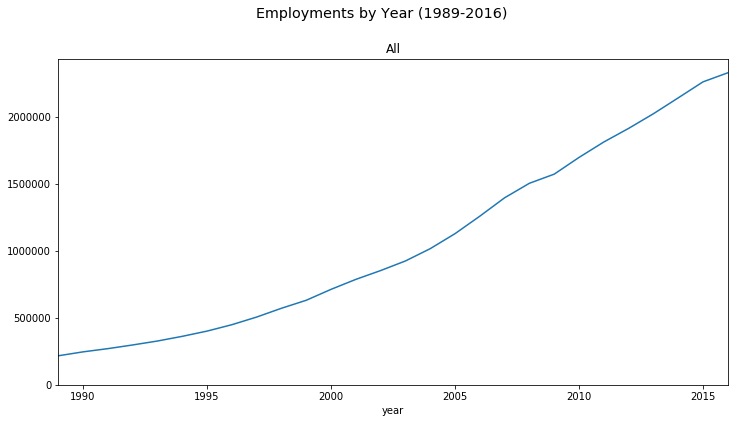

In [18]:
# count_by_years = pd.DataFrame({'count':empl_changes_df.groupby(['ticker','type','year']).size()}).reset_index()
# empl_by_years = count_by_years.groupby(['ticker','type']).apply(
#     lambda df:df.sort_values(['year']).assign(cumsum = lambda df2:df2['count'].cumsum()) # Calculate cumsum.
# ).reset_index(drop=True).pivot_table(
#     index=['ticker','year'],columns='type',values=['cumsum'],fill_value=0 # Reshape to wide format.
# ).assign(
#     employment=lambda df:(df['cumsum']['hiring']-df['cumsum']['firing']-df['cumsum']['leaving']) # Get employment.
# ).drop('cumsum',axis=1).reset_index()
# empl_by_years.columns = empl_by_years.columns.droplevel('type')

# Plot.
for (ticker, col), ax in zip(
    empl_by_years.pivot_table(
        index='year',columns='ticker',values='employment',fill_value=0
    ).loc[lambda df:(df.index>=1989)&(df.index<=2016)].iteritems(),
    iterator_for_axis(fig_func=lambda x:x.suptitle("Employments by Year (1989-2016)",fontsize="x-large",y=1))
):
    col.plot(ax=ax, title=ticker).set_ylim(bottom=0)

plt.show()

## Overall trends.
Note: Plots by year and plots by months do not only differ in frequency, but also in sample size. This is due to the entries without valid month record.

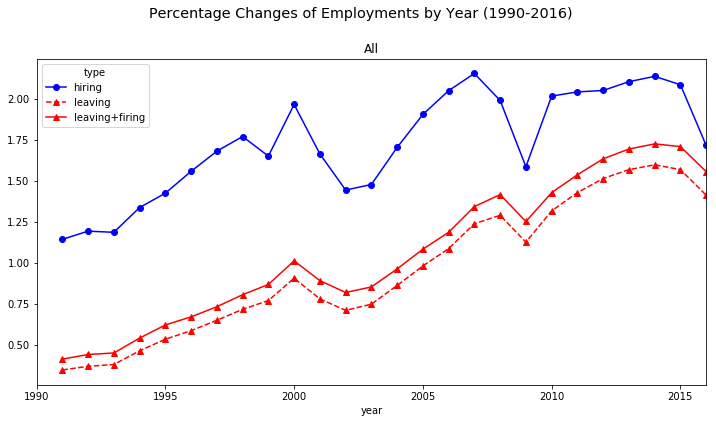

In [19]:
# Count and calculate percentages of employment changes.
prop_by_months = pd.DataFrame(
    {'count':empl_changes_df.groupby(['ticker','type','year','month']).size()} # Count by month.
).reset_index().merge(
    right=empl_by_years.assign(year_1L=lambda df:df.year+1)[['ticker','year_1L','employment']],
    left_on = ['ticker','year'], right_on = ['ticker','year_1L'] # Merge with last year's employment.
).assign(
    prop=lambda df:df['count']/df['employment']*100 # Calculate proportions.
).drop(
    ['count','year_1L','employment'],axis=1 # Drop unnecessary variables.
).loc[lambda df:(df.year>=1991)&(df.year<=2016)] # Keep only [1990, 2016] segment.

# prop_by_months.pivot_table(
#     index = ['ticker','year'], columns = 'type', values = 'prop', fill_value=0
# ).reset_index().assign(
#     **{"leaving+firing":lambda df:df.leaving+df.firing}
# ).drop("firing",axis=1).drop('ticker',axis=1).loc[lambda df:df.year>=xleft].set_index('year').plot(
#     xticks=[1990,1995,2000,2005,2010,2015], xlim=(xleft,2016), style=['b-o','r--^','r-^'],
#     title="Percentage Changes of Employments by Year (1990-2016)", figsize=(12,6)
# )


# Plot by year.
for (ticker, grp), ax, xleft in zip(
    prop_by_months.pivot_table(
        index = ['ticker','year'], columns = 'type', values = 'prop', fill_value=0
    ).reset_index().assign(
        **{"leaving+firing":lambda df:df.leaving+df.firing}
    ).drop("firing",axis=1).groupby('ticker'),
    iterator_for_axis(fig_func=lambda x:x.suptitle("Percentage Changes of Employments by Year (1990-2016)", fontsize="x-large", y=1)),
    xlefts
):
    grp.drop('ticker',axis=1).loc[lambda df:df.year>=xleft].set_index('year').plot(
        ax=ax, title=ticker, xticks=[1990,1995,2000,2005,2010,2015], xlim=(xleft,2016), style=['b-o','r--^','r-^']
    )
plt.show()

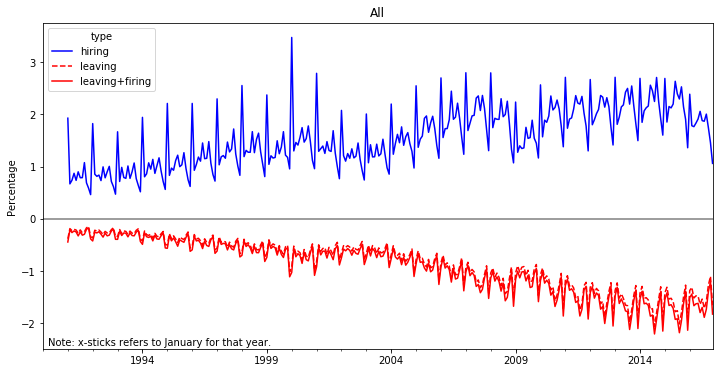

In [20]:
start_year=1990
end_year=2016
for (ticker, grp),ax,xleft in zip(
    prop_by_months.loc[lambda df:(df.month!=0)&(df.year>=start_year)&(df.year<=end_year)].pivot_table(
        index = ['ticker','year','month'], columns='type', values = 'prop', fill_value=0
    ).reset_index().assign(
        **{
            "leaving+firing":lambda df:-(df.leaving+df.firing),
            "leaving":lambda df:-df.leaving,
            "yrmth":lambda df:pd.PeriodIndex(year=df.year,month=df.month,freq='M')
        }
    ).set_index('yrmth').groupby('ticker'),
    iterator_for_axis(), xlefts
):
    grp.loc[lambda df:df.year>=xleft][['hiring','leaving','leaving+firing']].plot(
        ax=ax,title=ticker,style=['b-','r--','r-'],
        xlim=(pd.Period('{}-01'.format(xleft)),pd.Period('{}-12'.format(2016))),
        #xticks=[pd.Period('{}-01'.format(int(x*5+1990))) for x in range(5)]
    )
    ax.set_ylabel('Percentage')
    ax.set_xlabel('')
    ax.hlines(0,pd.Period('{}-01'.format(xleft)),pd.Period('{}-12'.format(2016)),colors='tab:gray')
    ax.annotate("Note: x-sticks refers to January for that year.",(5,3),xycoords="axes points")
plt.show()

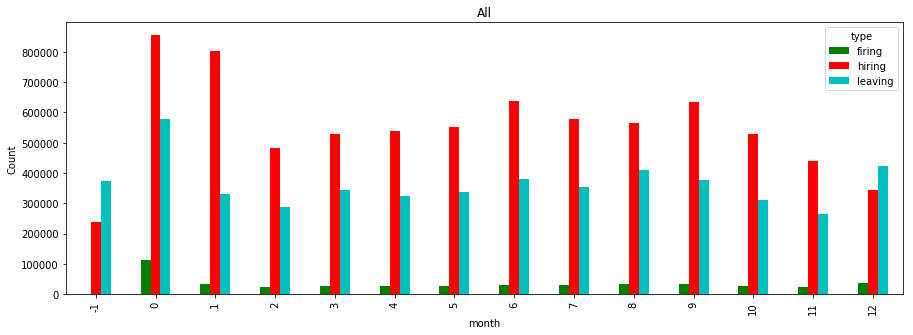

In [21]:
# Month composition.
display(HTML("<center><strong>Month Composition (-1: None, 0: Invalid month)</strong></center>"))
for idx, grp in empl_changes_df.groupby(['ticker']):
    grp.assign(count=1).pivot_table(
        index = 'month', columns = 'type', values='count', aggfunc='sum', fill_value=0
    ).plot.bar(figsize=(15,5),color=color_styles,title=idx).set_ylabel("Count")
    plt.show()

## By birth group.
Note: Birth year `2000` seems to be a trash bin for problematic records and thus will be treated the same as `None`.

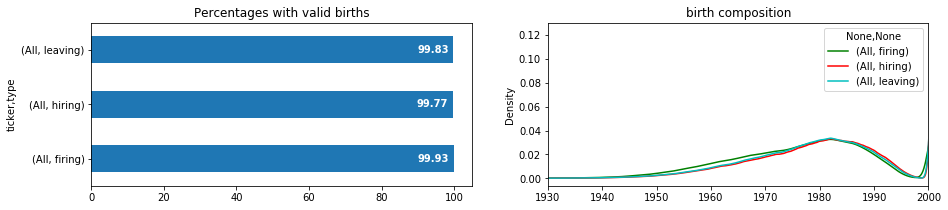

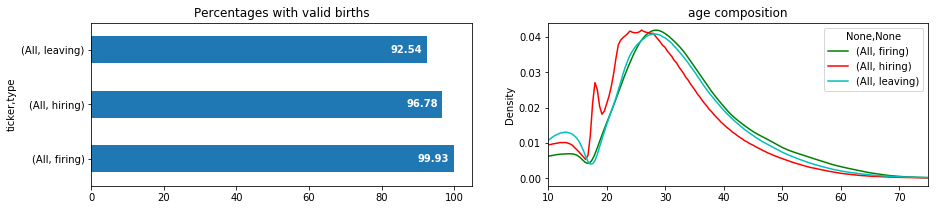

In [22]:
birth_df = empl_changes_df[['ticker','type','year','birth']]
birth_df = birth_df.assign(
    birth = lambda df:df.birth.apply(lambda x:int(x) if x not in ['2000','None'] else np.nan),
    age = lambda df:(df.year-df.birth)
)

# Define a routine to generate plots.
var, xlim = "birth", (1930,2000)
for ticker, grp in birth_df.groupby('ticker'):
    plt.subplots(1,2,figsize=(15,3))
    plt.subplot(121)
    to_plot = grp.groupby(['ticker','type']).apply(lambda df:(df.loc[~df[var].isnull()].size/df.size*100))
    ax = to_plot.plot.barh(title="Percentages with valid births")
    for idx, value in enumerate(to_plot):
        ax.text(value-10,idx-0.05,'{:.2f}'.format(value),color='white',fontweight='bold')
    plt.subplot(122)
    for (idx, group), color in zip(grp.loc[~grp[var].isnull()].groupby(['ticker','type']),color_styles):
        group[var].plot.kde(xlim=xlim,label=idx,title="{} composition".format(var),color=color,legend=True)
    plt.show()
var, xlim = "age", (10,75)
for ticker, grp in birth_df.groupby('ticker'):
    plt.subplots(1,2,figsize=(15,3))
    plt.subplot(121)
    to_plot = grp.groupby(['ticker','type']).apply(lambda df:(df.loc[~df[var].isnull()].size/df.size*100))
    ax = to_plot.plot.barh(title="Percentages with valid births")
    for idx, value in enumerate(to_plot):
        ax.text(value-10,idx-0.05,'{:.2f}'.format(value),color='white',fontweight='bold')
    plt.subplot(122)
    for (idx, group), color in zip(grp.loc[~grp[var].isnull()].groupby(['ticker','type']),color_styles):
        group[var].plot.kde(xlim=xlim,label=idx,title="{} composition".format(var),color=color,legend=True)
    plt.show()

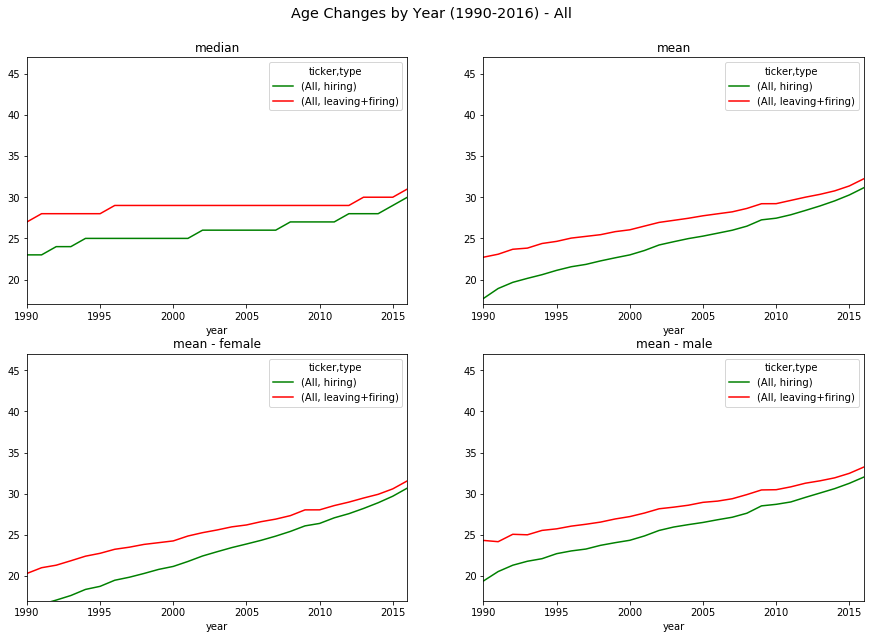

In [23]:
# Age changes by year.
for (ticker, grp), xleft in zip(
    birth_df.replace(
        to_replace={"type":{"firing":"leaving+firing","leaving":"leaving+firing"}}
    ).groupby('ticker'),
    xlefts
):
    fig, ((ax11, ax12), (ax21, ax22))=plt.subplots(2,2,figsize=(15,10))
    fig.suptitle('Age Changes by Year (1990-2016) - {}'.format(ticker),fontsize='x-large',y=0.95)
    grp.pivot_table(
        index='year',columns=['ticker','type'],values='age',aggfunc='median'
    ).plot(xlim=(xleft,2016),ylim=(17,47),color=color_styles,ax=ax11,title='median')
    grp.pivot_table(
        index='year',columns=['ticker','type'],values='age',aggfunc='mean'
    ).plot(xlim=(xleft,2016),ylim=(17,47),color=color_styles,ax=ax12,title='mean')
    grp.loc[empl_changes_df.gender=='1'].pivot_table(
        index='year',columns=['ticker','type'],values='age',aggfunc='mean'
    ).plot(xlim=(xleft,2016),ylim=(17,47),color=color_styles,ax=ax21,title='mean - female')
    grp.loc[empl_changes_df.gender=='2'].pivot_table(
        index='year',columns=['ticker','type'],values='age',aggfunc='mean'
    ).plot(xlim=(xleft,2016),ylim=(17,47),color=color_styles,ax=ax22,title='mean - male')
    plt.show()

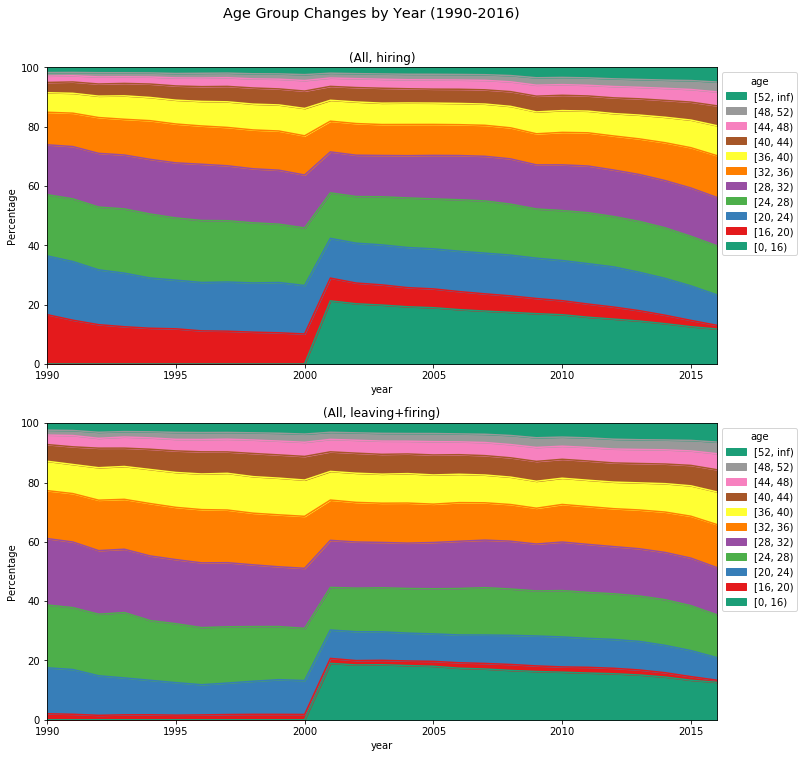

In [24]:
# Age group changes by year.
f_none_hidden = False # Whether to hide the ones out of [16, 52)
bins = list(np.arange(16,55,4))
colormap_unif = list(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)[:len(bins)-1]
if not f_none_hidden:
    bins = [0]+bins+[np.inf]
    colormap_unif = [plt.get_cmap('Dark2').colors[0]]+colormap_unif+[plt.get_cmap('Dark2').colors[0]]

# Plot composition changes by years.
for (idx, grp), ax, xleft in zip(
    birth_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','age']
    ].replace(
        to_replace={"type":{"firing":"leaving+firing","leaving":"leaving+firing"}}
    ).groupby(['ticker','type']), iterator_for_axis(
        rep_time=2, fig_func=lambda x:x.suptitle("Age Group Changes by Year (1990-2016)", fontsize='x-large', y=0.95)
    ), [x for x in xlefts for _ in range(2)]
):
    to_plot = grp.assign(count=1).pivot_table(
        index='year', columns=pd.cut(grp.age, bins, right=False, labels=False), values='count', aggfunc='sum', fill_value=0
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.plot(
        kind='area', ax=ax, ylim=(0,100), title=str(idx).replace("'",""),xlim=(xleft,2016),
        color=[colormap_unif[int(float(i))] for i in to_plot.columns],
        xticks=[1990,1995,2000,2005,2010,2015]
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), ["[{}, {})".format(bins[int(float(x))], bins[int(float(x))+1]) for x in reversed(labels)], 
        loc='upper left',bbox_to_anchor=(1,1),title='age'
    )
plt.show()

## By Gender.

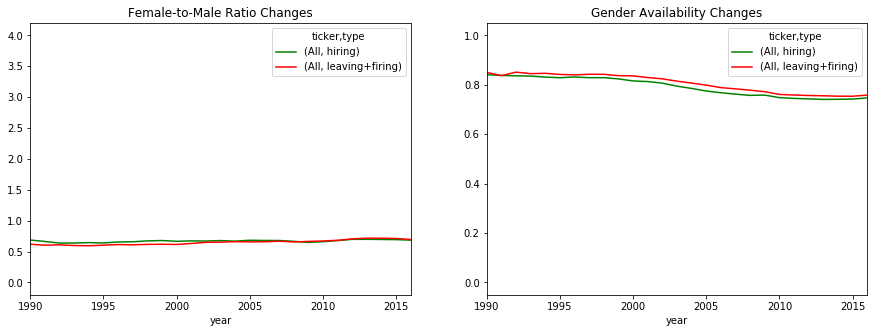

In [25]:
for (ticker, grp), xleft in zip(
    empl_changes_df.replace(
        to_replace={"type":{"firing":"leaving+firing","leaving":"leaving+firing"}}
    ).groupby('ticker'),
    xlefts
):
    fig, (ax1, ax2)=plt.subplots(1,2,figsize=(15,5))
    grp.pivot_table(
        index='year',columns=['ticker','type'],values='gender',
        aggfunc=lambda x:((x=='1').sum()/(x=='2').sum() if (x=='2').sum() else np.nan)
    ).plot(
        xlim=(xleft,2016),color=color_styles,title="Female-to-Male Ratio Changes",ax=ax1,
        xticks=[1990+5*x for x in range(6)]
    )
    grp.pivot_table(
        index='year',columns=['ticker','type'],values='gender',
        aggfunc=lambda x:((x!='0').sum()/x.size)
    ).plot(
        xlim=(xleft,2016),color=color_styles,title="Gender Availability Changes",ax=ax2,
        xticks=[1990+5*x for x in range(6)]
    )
    plt.show()

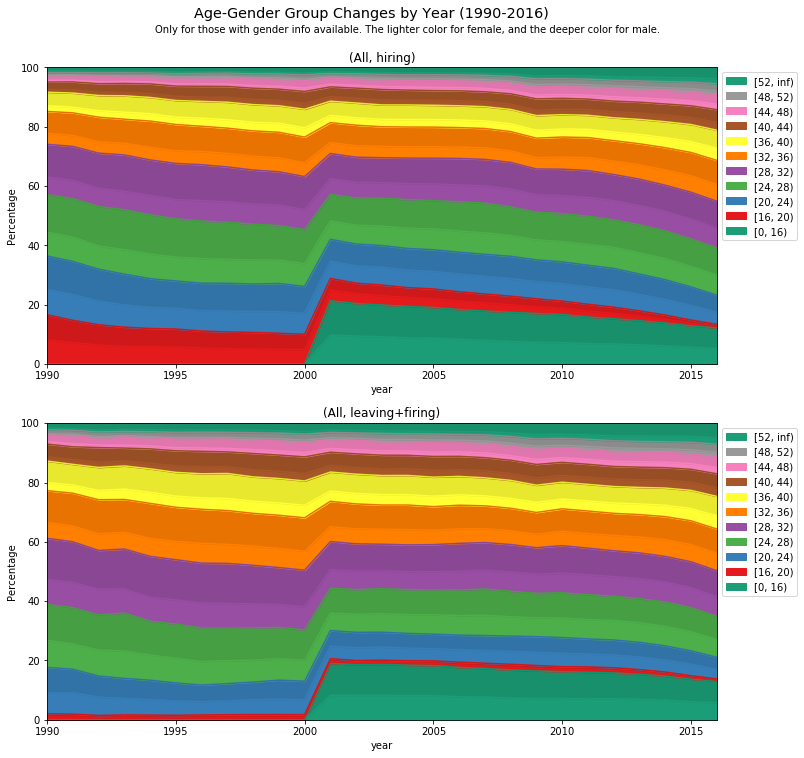

In [26]:
# Age group changes by year.
f_none_hidden = False # Whether to hide the ones out of [16, 52)
bins = list(np.arange(16,55,4))
colormap_unif = list(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)[:len(bins)-1]
if not f_none_hidden:
    bins = [0]+bins+[np.inf]
    colormap_unif = [plt.get_cmap('Dark2').colors[0]]+colormap_unif+[plt.get_cmap('Dark2').colors[0]]

# Plot composition changes by years.
def fig_func(fig):
    fig.suptitle("Age-Gender Group Changes by Year (1990-2016)", fontsize='x-large', y=0.95)
    fig.text(0.25,0.92,
          "Only for those with gender info available. The lighter color for female, and the deeper color for male.")
for (idx, grp), ax, xleft in zip(
    birth_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016)&(empl_changes_df.gender!='0'), ['ticker','type','year','age']
    ].replace(
        to_replace={"type":{"firing":"leaving+firing","leaving":"leaving+firing"}}
    ).groupby(['ticker','type']), iterator_for_axis(
        rep_time=2, fig_func=fig_func
    ), [x for x in xlefts for _ in range(2)]
):
    to_plot = grp.assign(count=1).pivot_table(
        index='year', columns=[pd.cut(grp.age, bins, right=False, labels=False), empl_changes_df.gender], 
        values='count', aggfunc='sum', fill_value=0
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.plot(
        kind='area', ax=ax, ylim=(0,100), title=str(idx).replace("'",""), 
        xlim=(xleft,2016), xticks=[1990+5*x for x in range(6)],
        color=[
            colormap_unif[int(float(i))] if j=='1' else tuple(t/1.1 for t in colormap_unif[int(float(i))]) 
            for i,j in to_plot.columns
        ]
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed([handles[i] for i in range(len(handles)) if i%2==0]), 
        reversed(["[{}, {})".format(bins[int(float(x))], bins[int(float(x))+1]) for x in
            [re.match(r"\((\d+)\.0",labels[i]).group(1) for i in range(len(labels)) if i%2==0]
        ]), 
        loc='upper left',bbox_to_anchor=(1,1)
    )
plt.show()

## By Primary Skill.

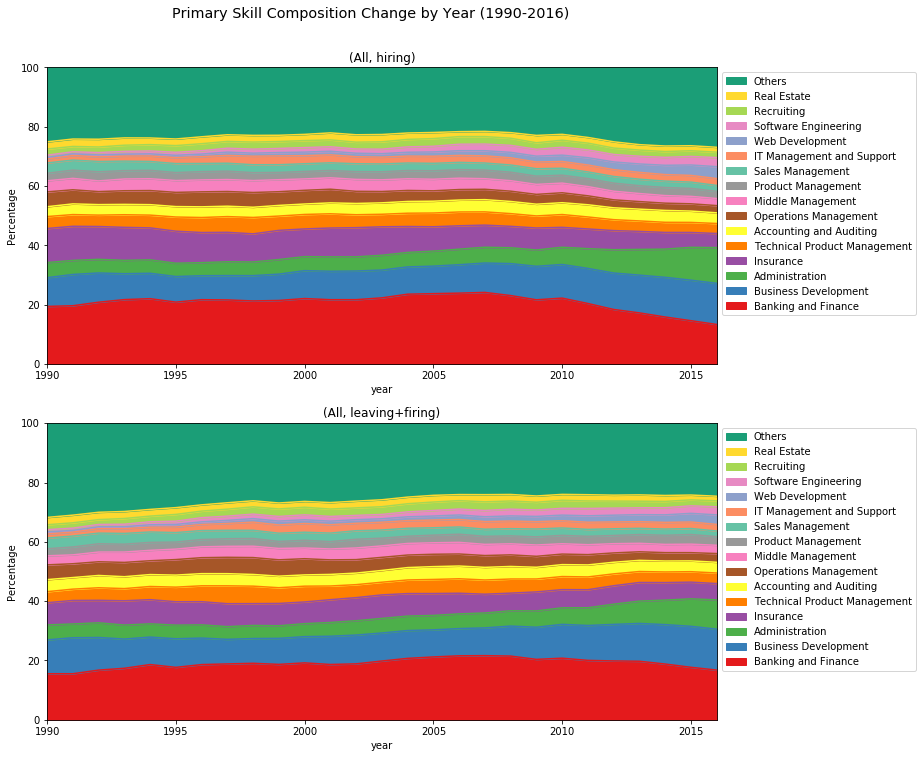

In [27]:
# Create a uniform colormap for all subplots.
skill1_ord_unif = empl_changes_df.groupby('skill1').size().sort_values(ascending=False).index.tolist()
colormap_unif = {idx:clr for idx, clr in zip(
    skill1_ord_unif,
    itertools.cycle(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)
)}
colormap_unif['Others'] = plt.get_cmap('Dark2').colors[0]

# Codes for showing pie charts:
# fig,axs=plt.subplots(3,2,figsize=(15,22.5))
# fig.suptitle("Secondary Skill Composition",fontsize='x-large')
# for (idx,col),ax in zip(
#     empl_changes_df.loc[:].pivot_table(
#         index='skill1',columns=['ticker','type'],values='gender',aggfunc='count'
#     ).iteritems(), itertools.chain.from_iterable(axs)
# ):
#     to_plot0 = col.sort_values(ascending=False)
#     to_plot = to_plot0.iloc[0:18]
#     to_plot.loc['Others']=to_plot0.sum()-to_plot.sum()  
#     ax=to_plot.plot.pie(
#         ax=ax,labeldistance=1.05,title=str(idx).replace("'",''),autopct='%.2f',pctdistance=0.9,
#         colors = [colormap_unif[idx] for idx in to_plot.index]
#     )
#     ax.set_ylabel('')
# plt.show()

## Continued ##
N_cats = 15 # Number of categories to be shown.

# Plot composition changes by years.
for (idx, grp), ax, xleft in zip(
    empl_changes_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','skill1']
    ].replace(
        to_replace={"type":{"firing":"leaving+firing","leaving":"leaving+firing"}}
    ).groupby(['ticker','type']), iterator_for_axis(
        rep_time=2, fig_func=lambda x:x.suptitle("Primary Skill Composition Change by Year (1990-2016)", fontsize='x-large', y=0.95)
    ), [x for x in xlefts for _ in range(2)]
):
    to_plot = grp.assign(
        skill1_id = lambda df:[
            {val:(idx if idx<N_cats else N_cats) for idx, val in enumerate(skill1_ord_unif)}[x] for x in df.skill1
        ], count = 1
    ).pivot_table(
        index='year', columns='skill1_id', values='count', aggfunc='sum', fill_value=0 
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.columns = [skill1_ord_unif[i] if i<N_cats else "Others" for i in to_plot.columns]
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        ylim=(0,100), title=str(idx).replace("'",""), 
        xlim=(xleft,2016), xticks=[1990,1995,2000,2005,2010,2015]
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), reversed(['\n'.join(wrap(x,30)) for x in labels]), 
        loc='upper left',bbox_to_anchor=(1,1)
    )
plt.show()

In [28]:
edu_lablst = {
    0:"None/Unknown", 1:"High school", 2:"Vocational degree", 3:"Associates", 
    4:"Bachelors", 5:"Masters excl. MBA", 6:"MBA", 7:"Doctorate (PhD/JD/MD)"
}

# Find representative profiles.
for i in range(5):
    display(HTML("<strong>"+skill1_ord_unif[i]+"</strong>"))
    to_plot = empl_changes_df.assign(edu=lambda df:df.edu.apply(lambda x:edu_lablst[int(x)])).loc[
        lambda df:(df.skill1==skill1_ord_unif[i]),
        ["job_role","depmt","edu","f_elite"]
    ]
    N = to_plot.shape[0]
    # Job role.
    varname = "job_role"
    top10_job_role = pd.DataFrame([v
        for w in to_plot.groupby(varname).size().reset_index().apply(
        lambda x:[[x[varname].split(',')[0].title(),x[0]]]
        #lambda x:[[y.title(),z] for y in x[varname].split(',') for z in [x[0]/(x[varname].count(',')+1)]]
        ,axis=1) for v in w
    ],columns=[varname,"count"]).groupby(varname).sum().reset_index().sort_values(
        "count",ascending=False
    ).head(10).assign(
        prop=lambda df:(df["count"]/N*100).apply(round,ndigits=2)
    ).reset_index(drop=True)#.drop("count",axis=1)
    # Department.
    varname = "depmt"
    to_plot_depmt = to_plot.loc[lambda df:df[varname]!='']
    N_depmt = to_plot_depmt.shape[0]
    top10_depmt = pd.DataFrame([v
        for w in to_plot_depmt.groupby(varname).size().reset_index().apply(
        lambda x:[[y.title(),z] for y in x[varname].split(',') for z in [x[0]/(x[varname].count(',')+1)]]
        ,axis=1) for v in w
    ],columns=[varname,"count"]).replace(
        {varname:{"Tehnology":"Technology"}}
    ).groupby(varname).sum().reset_index().sort_values(
        "count",ascending=False
    ).head(10).assign(
        prop=lambda df:(df["count"]/N_depmt*100).apply(round,ndigits=2)
    ).reset_index(drop=True).drop("count",axis=1)
    # Education.
    top10_edu = to_plot.groupby("edu").size().sort_values(ascending=False).apply(
        lambda x:round(x/N*100,2)).rename("prop").reset_index()
    # show.
    display(HTML("<em>Top 10 entries for each variables with proportions:</em>"))
    display(pd.concat([top10_job_role,top10_depmt,top10_edu], axis=1))
    # Some examples.
    to_plot = to_plot.sample(30)
    display(HTML("<em>Some examples:</em>"))
    display(to_plot)
    

,job_role,count,prop,depmt,prop,edu,prop
0,Vice President,49276,1.94,Accounting,38.11,Bachelors,38.54
1,Analyst,32708,1.29,Oversight,20.38,None/Unknown,26.98
2,Branch Manager,30401,1.20,Marketing,14.97,Masters excl. MBA,14.51
3,Associate,27356,1.08,Business,10.46,MBA,13.21
4,Director,26475,1.04,Operations,6.52,Doctorate (PhD/JD/MD),2.47
5,Managing Director,24464,0.96,Technology,4.47,High school,2.25
6,Relationship Manager,20065,0.79,Hr,3.05,Associates,1.20
7,Manager,16450,0.65,Legal,0.89,Vocational degree,0.84
8,Financial Advisor,14315,0.56,Management,0.58,NaN,NaN
9,Personal Banker,13201,0.52,Production,0.55,NaN,NaN


,job_role,depmt,edu,f_elite
10099512,"Managing Director,managing director",OVERSIGHT,MBA,False
7907548,"Senior Business Development Manager,business development manager,senior",BUSINESS,Bachelors,False
538561,"Senior Manager,senior manager",,Bachelors,False
1900744,"Support Manager,support,manager",MARKETING,None/Unknown,False
5900614,"Portfolio Manager,portfolio manager",,None/Unknown,False
1605652,"Graduate Analyst,graduate,analyst",,Bachelors,False
12864920,"AVP - Capital Introduction,vice president,assistant",,Bachelors,True
8493731,"VP - Structure Finance Mortgage Analytics,vice president,finance","ACCOUNTING,BUSINESS",Bachelors,False
725534,"Derivatives Sales,sales",MARKETING,None/Unknown,False
6839309,"Principal Client Advisory Group,principal,"","",client",,MBA,True


,job_role,count,prop,depmt,prop,edu,prop
0,Estagiário,11551,0.76,Marketing,33.66,Bachelors,34.96
1,Stagiaire,7439,0.49,Accounting,19.92,None/Unknown,26.67
2,Estagiária,6835,0.45,Business,13.79,Masters excl. MBA,20.58
3,Sales Manager,5009,0.33,Oversight,9.62,MBA,8.14
4,Analyst,4490,0.30,Operations,6.29,High school,4.20
5,Administrative Assistant,4406,0.29,Hr,5.40,Vocational degree,3.64
6,Customer Service Representative,4361,0.29,Technology,4.99,Doctorate (PhD/JD/MD),1.27
7,Auxiliar Administrativo,4245,0.28,Management,3.45,Associates,0.53
8,Consultant,3842,0.25,Production,1.63,NaN,NaN
9,Manager,3723,0.25,Legal,1.24,NaN,NaN


,job_role,depmt,edu,f_elite
474589,-,,Bachelors,False
4323188,"Service Level Consultant,service,consultant",MARKETING,None/Unknown,False
10066504,"Financial Advisor,financial advisor",ACCOUNTING,MBA,False
3827247,"Consultora de Vendas,consultora de vendas",,Bachelors,False
5499669,"Estagiária e Caixa,estagiária,caixa",,Bachelors,False
8156242,operador de mesa de dinero,,Bachelors,False
637200,"Account Manager,account manager",,Masters excl. MBA,False
9563110,"Directeur de groupe d'agences,directeur",,None/Unknown,False
9215558,"Supervisora Dpto Call Center,call center,supervisora",,Bachelors,False
4948768,Atendimento ao cliente,,Masters excl. MBA,False


,job_role,count,prop,depmt,prop,edu,prop
0,Customer Service Representative,25965,2.65,Accounting,33.86,Bachelors,49.06
1,Administrative Assistant,18715,1.91,Marketing,33.65,None/Unknown,25.27
2,Teller,13818,1.41,Hr,7.71,Masters excl. MBA,8.44
3,Bank Teller,13389,1.37,Operations,7.47,High school,5.80
4,Executive Assistant,12865,1.31,Business,5.07,Associates,5.25
5,Financial Advisor,5895,0.60,Oversight,4.99,MBA,3.04
6,Financial Representative,5471,0.56,Technology,3.72,Vocational degree,2.12
7,Office Manager,5462,0.56,Legal,1.45,Doctorate (PhD/JD/MD),1.03
8,Analyst,5196,0.53,Production,1.32,NaN,NaN
9,Personal Banker,5110,0.52,Management,0.75,NaN,NaN


,job_role,depmt,edu,f_elite
9638623,"Financial Analyst,financial analyst",ACCOUNTING,Masters excl. MBA,False
5791498,"Financial Services Representative,financial,services,representative","HR,ACCOUNTING",Bachelors,False
5511675,"COBRA/Flexible Spending Account Eligibility,account",,None/Unknown,False
9221062,"Projects Coordinator,coordinator",,Bachelors,False
9415015,"Credit Officer,credit officer",ACCOUNTING,None/Unknown,False
1649313,adjointe de direction,,None/Unknown,False
9319032,"Research Assistant,research assistant",TECHNOLOGY,None/Unknown,False
9498097,"Tax Preparer,tax preparer",ACCOUNTING,Bachelors,False
11424463,"Insurance Broker/Deposit Broker,insurance,broker",ACCOUNTING,None/Unknown,False
12797788,"Contractor,contractor",,Bachelors,False


,job_role,count,prop,depmt,prop,edu,prop
0,Financial Advisor,28857,3.07,Accounting,43.70,None/Unknown,42.08
1,Agent,12238,1.30,Marketing,19.49,Bachelors,39.77
2,Account Executive,12051,1.28,Oversight,13.88,Masters excl. MBA,5.53
3,Account Manager,11776,1.25,Business,11.00,MBA,4.71
4,Insurance Agent,11671,1.24,Hr,5.42,High school,3.11
5,Vice President,9146,0.97,Operations,3.22,Associates,2.09
6,Underwriter,7895,0.84,Technology,1.38,Doctorate (PhD/JD/MD),1.56
7,Financial Planner,5240,0.56,Production,0.82,Vocational degree,1.15
8,Claims Adjuster,5139,0.55,Legal,0.66,NaN,NaN
9,Financial Representative,5106,0.54,Management,0.46,NaN,NaN


,job_role,depmt,edu,f_elite
4070699,"Senior Service Representative,senior,service,representative",MARKETING,None/Unknown,False
9515415,"Licensed Financial Specialist,financial,specialist",ACCOUNTING,Masters excl. MBA,False
4196577,Administrativ assistent,,None/Unknown,False
6208396,"President Custom Guarantee Group,president",,Bachelors,False
502066,"Sales Advisor,sales advisor",MARKETING,Vocational degree,False
6122516,"Account Manager,account manager",,None/Unknown,False
967434,"Account Executive,account executive",,Bachelors,False
789303,"Technical Training Analyst / Quality Assurance and Development,quality assurance,technical,training,analyst,development","HR,PRODUCTION",None/Unknown,False
9466775,Mortgage Originator,ACCOUNTING,Bachelors,True
11076763,"Independent Agent,independent,agent",,Bachelors,False


,job_role,count,prop,depmt,prop,edu,prop
0,Business Analyst,16632,3.12,Technology,44.28,Bachelors,42.77
1,Project Manager,8537,1.60,Business,12.79,None/Unknown,28.93
2,Consultant,7946,1.49,Marketing,9.68,Masters excl. MBA,15.60
3,Senior Business Analyst,5876,1.10,Accounting,9.09,MBA,6.79
4,Software Engineer,4406,0.83,Operations,6.61,High school,2.22
5,Systems Analyst,3162,0.59,Oversight,6.43,Doctorate (PhD/JD/MD),1.58
6,Software Developer,2976,0.56,Production,5.15,Associates,1.22
7,Analyst,2531,0.48,Hr,3.09,Vocational degree,0.88
8,Senior Software Engineer,2491,0.47,Legal,2.58,NaN,NaN
9,System Analyst,2437,0.46,Management,0.30,NaN,NaN


,job_role,depmt,edu,f_elite
6090742,"Specialist Developer,specialist,developer",,Bachelors,False
856316,".NET/SQL/Reporting Development Consultant,development,consultant",,None/Unknown,False
7434036,"Software Quality Assurance Analyst,quality assurance,software,analyst","PRODUCTION,TECHNOLOGY",Bachelors,False
12466738,"PeopleSoft Systems Analyst,systems analyst",TECHNOLOGY,Vocational degree,False
10072039,"Database Engineer,engineer",,Bachelors,False
9690064,"Data Warehouse Lead,data,warehouse,lead",OPERATIONS,Masters excl. MBA,False
7893780,"CSR,customer service representative",,Masters excl. MBA,False
9401485,"Database Administrator PeopleSoft Administrator and Technical Lead,database administrator,"","",technical,lead",,Masters excl. MBA,False
6009631,ведущий специалист,,Bachelors,False
9293705,"Manager Business Analysis,manager,"","",business",,MBA,False


## By Secondary Skill.
Only for those with their primary skill of "Banking and Finance".

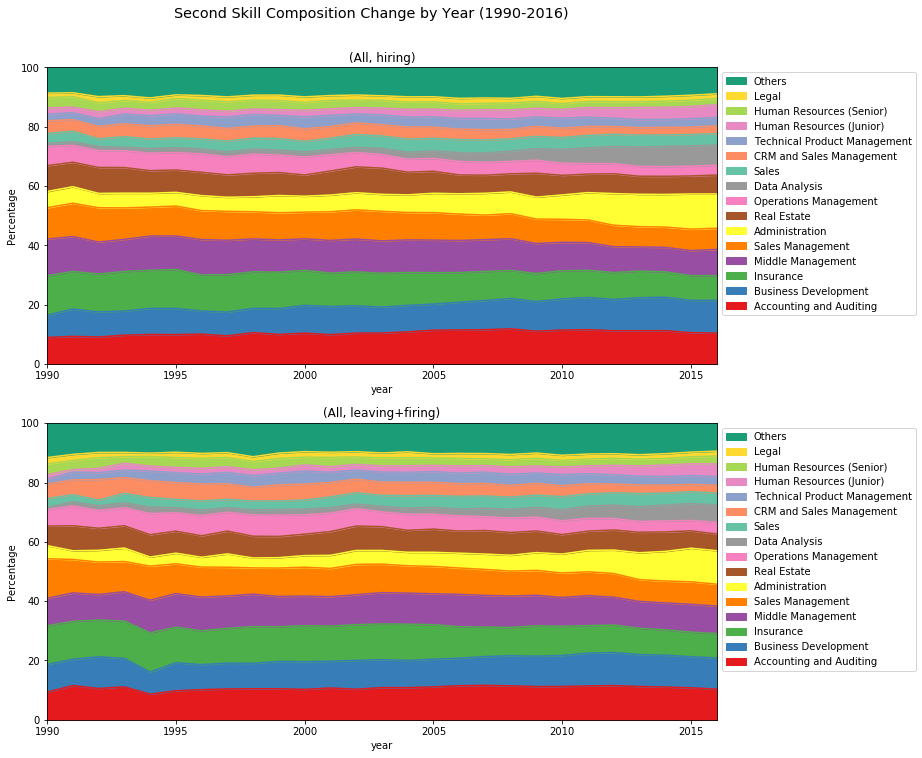

In [29]:
skill2_to_plot = empl_changes_df.loc[lambda df:(df.skill2!='')&(df.skill1=="Banking and Finance")]

# Create a uniform colormap for all subplots.
skill2_ord_unif = skill2_to_plot.groupby('skill2').size().sort_values(ascending=False).index.tolist()
colormap_unif = {idx:clr for idx, clr in zip(
    skill2_ord_unif,
    itertools.cycle(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)
)}
colormap_unif['Others'] = plt.get_cmap('Dark2').colors[0]

# Codes for showing pie charts:
# fig,axs=plt.subplots(3,2,figsize=(15,22.5))
# fig.suptitle("Secondary Skill Composition",fontsize='x-large')
# for (idx,col),ax in zip(
#     skill2_to_plot.loc[:].pivot_table(
#         index='skill2',columns=['ticker','type'],values='gender',aggfunc='count'
#     ).iteritems(), itertools.chain.from_iterable(axs)
# ):
#     to_plot0 = col.sort_values(ascending=False)
#     to_plot = to_plot0.iloc[0:18]
#     to_plot.loc['Others']=to_plot0.sum()-to_plot.sum()  
#     ax=to_plot.plot.pie(
#         ax=ax,labeldistance=1.05,title=str(idx).replace("'",''),autopct='%.2f',pctdistance=0.9,
#         colors = [colormap_unif[idx] for idx in to_plot.index]
#     )
#     ax.set_ylabel('')
# plt.show()

## Continued ##
N_cats = 15 # Number of categories to be shown.

# Plot composition changes by years.
for (idx, grp), ax, xleft in zip(
    skill2_to_plot.loc[lambda df:df.skill2!=''].loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','skill2']
    ].replace(
        to_replace={"type":{"firing":"leaving+firing","leaving":"leaving+firing"}}
    ).groupby(['ticker','type']), iterator_for_axis(
        rep_time=2, fig_func=lambda x:x.suptitle("Second Skill Composition Change by Year (1990-2016)", fontsize='x-large', y=0.95)
    ), [x for x in xlefts for _ in range(2)]
):
    to_plot = grp.assign(
        skill2_id = lambda df:[
            {val:(idx if idx<N_cats else N_cats) for idx, val in enumerate(skill2_ord_unif)}[x] for x in df.skill2
        ], count = 1
    ).pivot_table(
        index='year', columns='skill2_id', values='count', aggfunc='sum', fill_value=0 
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.columns = [skill2_ord_unif[i] if i<N_cats else "Others" for i in to_plot.columns]
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        ylim=(0,100), title=str(idx).replace("'",""), 
        xlim=(xleft,2016), xticks=[1990,1995,2000,2005,2010,2015]
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), reversed(['\n'.join(wrap(x,30)) for x in labels]), 
        loc='upper left',bbox_to_anchor=(1,1)
    )
plt.show()

In [30]:
edu_lablst = {
    0:"None/Unknown", 1:"High school", 2:"Vocational degree", 3:"Associates", 
    4:"Bachelors", 5:"Masters excl. MBA", 6:"MBA", 7:"Doctorate (PhD/JD/MD)"
}

# Find representative profiles.
for i in range(5):
    display(HTML("<strong>"+skill2_ord_unif[i]+"</strong>"))
    to_plot = skill2_to_plot.assign(edu=lambda df:df.edu.apply(lambda x:edu_lablst[int(x)])).loc[
        lambda df:(df.skill2==skill2_ord_unif[i]),
        ["job_role","depmt","edu","f_elite"]
    ]
    N = to_plot.shape[0]
    # Job role.
    varname = "job_role"
    top10_job_role = pd.DataFrame([v
        for w in to_plot.groupby(varname).size().reset_index().apply(
        lambda x:[[x[varname].split(',')[0].title(),x[0]]]
        #lambda x:[[y.title(),z] for y in x[varname].split(',') for z in [x[0]/(x[varname].count(',')+1)]]
        ,axis=1) for v in w
    ],columns=[varname,"count"]).groupby(varname).sum().reset_index().sort_values(
        "count",ascending=False
    ).head(10).assign(
        prop=lambda df:(df["count"]/N*100).apply(round,ndigits=2)
    ).reset_index(drop=True)#.drop("count",axis=1)
    # Department.
    varname = "depmt"
    to_plot_depmt = to_plot.loc[lambda df:df[varname]!='']
    N_depmt = to_plot_depmt.shape[0]
    top10_depmt = pd.DataFrame([v
        for w in to_plot_depmt.groupby(varname).size().reset_index().apply(
        lambda x:[[y.title(),z] for y in x[varname].split(',') for z in [x[0]/(x[varname].count(',')+1)]]
        ,axis=1) for v in w
    ],columns=[varname,"count"]).groupby(varname).sum().reset_index().sort_values(
        "count",ascending=False
    ).head(10).assign(
        prop=lambda df:(df["count"]/N_depmt*100).apply(round,ndigits=2)
    ).reset_index(drop=True).drop("count",axis=1)
    # Education.
    top10_edu = to_plot.groupby("edu").size().sort_values(ascending=False).apply(
        lambda x:round(x/N*100,2)).rename("prop").reset_index()
    # show.
    display(HTML("<em>Top 10 entries for each variables with proportions:</em>"))
    display(pd.concat([top10_job_role,top10_depmt,top10_edu], axis=1))
    # Some examples.
    to_plot = to_plot.sample(30).assign(
        job_role=lambda df:df.job_role.apply(lambda x:x.split(",")[0])
    )
    display(HTML("<em>Some examples:</em>"))
    display(to_plot)
    

,job_role,count,prop,depmt,prop,edu,prop
0,Financial Analyst,2143,1.37,Accounting,51.88,Bachelors,43.24
1,Analyst,2080,1.33,Oversight,18.82,None/Unknown,18.78
2,Vice President,2039,1.30,Business,7.98,Masters excl. MBA,17.93
3,Associate,1645,1.05,Operations,7.62,MBA,15.00
4,Manager,1258,0.81,Marketing,6.73,Doctorate (PhD/JD/MD),1.94
5,Credit Analyst,1191,0.76,Technology,2.76,High school,1.63
6,Fund Accountant,1113,0.71,Hr,2.55,Associates,0.78
7,Director,976,0.62,Legal,0.68,Vocational degree,0.70
8,Internal Auditor,926,0.59,Management,0.49,NaN,NaN
9,Assistant Manager,864,0.55,Production,0.49,NaN,NaN


,job_role,depmt,edu,f_elite
10553760,Community Reinvestment Act Officer,MARKETING,Bachelors,False
123697,Branch Operations Manager,OPERATIONS,None/Unknown,False
11911640,Customer Service Officer,MARKETING,Bachelors,False
7691695,Chief Financial Officer / CFO (interim),"ACCOUNTING,OVERSIGHT",MBA,False
1791678,Business Executive,,Masters excl. MBA,False
797990,Sr Manager,,None/Unknown,False
9689145,Member of Extended Management Board,,MBA,False
10424245,Financial Analyst Non-Retail Credit Risk Division,"ACCOUNTING,OVERSIGHT",Bachelors,False
2434596,Vice President,,Masters excl. MBA,False
4617188,Senior Credit Specialist,ACCOUNTING,Bachelors,False


,job_role,count,prop,depmt,prop,edu,prop
0,Analyst,2278,1.58,Accounting,36.15,Bachelors,33.41
1,Associate,1599,1.11,Marketing,18.09,Masters excl. MBA,22.45
2,Relationship Manager,1268,0.88,Oversight,16.30,None/Unknown,19.74
3,Investment Banking Analyst,1093,0.76,Business,15.00,MBA,18.45
4,Vice President,1004,0.70,Technology,4.92,High school,2.28
5,Financial Analyst,864,0.60,Operations,4.89,Doctorate (PhD/JD/MD),2.04
6,Director,823,0.57,Hr,2.77,Vocational degree,1.25
7,Manager,741,0.52,Management,1.04,Associates,0.38
8,Branch Manager,714,0.50,Legal,0.51,NaN,NaN
9,Assistant Manager,654,0.45,Production,0.32,NaN,NaN


,job_role,depmt,edu,f_elite
6766749,Relations investisseurs France,,Bachelors,False
12217422,Assessora Jurídica,,MBA,False
2311776,Wholesale Credit Global Banking & Markets,ACCOUNTING,Bachelors,True
6228356,Portfolio Manager,,Bachelors,False
6403643,Gérant Multi-Gestion / Risk Manager chez Amilton AM,OVERSIGHT,None/Unknown,False
5238004,Financial Direction at Société Générale Paris,ACCOUNTING,Masters excl. MBA,False
1413124,Sales Associate,MARKETING,Bachelors,False
1817876,Asst. Manager,,Masters excl. MBA,False
492930,Product Manager Cuentas Corrientes y Líneas de Crédito,,Masters excl. MBA,False
5184580,Relationship Manager,,Masters excl. MBA,False


,job_role,count,prop,depmt,prop,edu,prop
0,Financial Advisor,4704,3.30,Accounting,44.49,Bachelors,43.51
1,Vice President,2567,1.80,Oversight,19.62,None/Unknown,29.81
2,Branch Manager,1602,1.12,Marketing,16.23,MBA,10.67
3,Director,1320,0.93,Business,8.05,Masters excl. MBA,8.89
4,Managing Director,1302,0.91,Operations,4.18,High school,2.73
5,Relationship Manager,1122,0.79,Hr,4.08,Doctorate (PhD/JD/MD),2.15
6,Senior Vice President,1000,0.70,Technology,1.91,Associates,1.14
7,Personal Banker,932,0.65,Legal,0.57,Vocational degree,1.10
8,Investment Advisor,903,0.63,Management,0.50,NaN,NaN
9,Financial Consultant,893,0.63,Production,0.34,NaN,NaN


,job_role,depmt,edu,f_elite
1975317,Head of Key Accounts Intermediary Channel,,None/Unknown,False
9882571,Customer Service Specialist/Contact Centre,MARKETING,Masters excl. MBA,False
13061586,Owner,OVERSIGHT,None/Unknown,False
5692659,Wealth Manager,,MBA,False
12483735,Sales Administrator,MARKETING,Bachelors,False
1394994,Customer Account Manager,,High school,False
4131472,Managing Director - Investments,OVERSIGHT,Bachelors,False
11540060,Mortgage and Protection Advisor,ACCOUNTING,None/Unknown,False
3996215,Vice-President; Commercial Premier Client Manager,BUSINESS,Bachelors,False
11901987,Branch Manager,,None/Unknown,False


,job_role,count,prop,depmt,prop,edu,prop
0,Branch Manager,2099,1.49,Accounting,31.10,Bachelors,38.76
1,Vice President,1962,1.39,Oversight,17.31,None/Unknown,25.45
2,Manager,1347,0.95,Marketing,17.03,MBA,16.04
3,Assistant Manager,1045,0.74,Operations,13.67,Masters excl. MBA,12.40
4,Relationship Manager,899,0.64,Business,9.64,High school,2.65
5,Analyst,892,0.63,Hr,4.86,Doctorate (PhD/JD/MD),2.28
6,Director,839,0.59,Technology,3.78,Associates,1.48
7,Business Analyst,830,0.59,Production,1.11,Vocational degree,0.94
8,Associate,753,0.53,Legal,0.85,NaN,NaN
9,Project Manager,751,0.53,Management,0.63,NaN,NaN


,job_role,depmt,edu,f_elite
6830937,BMO Lynx Officer,,Bachelors,False
3159329,Business Analyst,,Masters excl. MBA,False
716722,Merchant Teller,,Bachelors,False
942628,Arbitre senior,,Masters excl. MBA,True
2728522,Account Manager,,Bachelors,False
1588499,CSC,,Bachelors,False
10610680,Third Party Processing,,Bachelors,False
9099673,ASC Floater,,Bachelors,False
4377621,Trading Assistant,ACCOUNTING,Bachelors,False
2928830,Telesales Executive,,Bachelors,False


,job_role,count,prop,depmt,prop,edu,prop
0,Branch Manager,3919,3.27,Accounting,34.99,Bachelors,40.23
1,Vice President,2331,1.94,Marketing,20.85,None/Unknown,26.81
2,Relationship Manager,1559,1.30,Oversight,18.10,MBA,14.60
3,Director,1183,0.99,Business,15.49,Masters excl. MBA,11.52
4,Managing Director,1076,0.90,Operations,4.94,High school,2.54
5,Manager,949,0.79,Hr,2.82,Doctorate (PhD/JD/MD),1.93
6,Personal Banker,906,0.76,Technology,1.60,Associates,1.52
7,Senior Vice President,831,0.69,Management,0.46,Vocational degree,0.85
8,Financial Advisor,785,0.65,Legal,0.44,NaN,NaN
9,Business Development Manager,762,0.64,Production,0.32,NaN,NaN


,job_role,depmt,edu,f_elite
1078093,Customer Service Officer,MARKETING,MBA,False
3585545,Vice President Business Banker,,None/Unknown,False
5675601,President,,None/Unknown,False
726806,Mortgage Loan Partner - Spanish Speaker,"ACCOUNTING,OVERSIGHT",Bachelors,False
2612940,Regional Manager in SME Finance Department,ACCOUNTING,Bachelors,False
6002606,Sales Director Aerospace & Defence,"MARKETING,OVERSIGHT",High school,False
12320044,Branch Operations Manager,OPERATIONS,Associates,False
3380482,Area Sales Manager - Personal Loan,"MARKETING,ACCOUNTING",None/Unknown,False
9220393,Doradca Biznesowy,,None/Unknown,False
5733635,Head of Partnerships,MANAGEMENT,None/Unknown,False


## By Country.

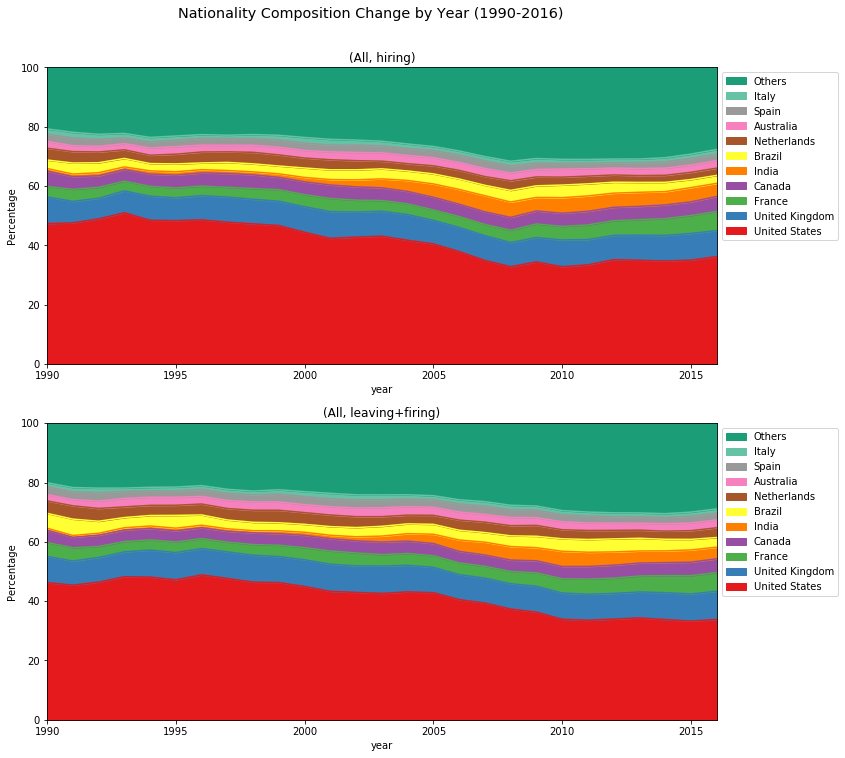

In [31]:
# Create a uniform colormap for all subplots.
cntry_ord_unif = empl_changes_df.groupby('cntry').size().sort_values(ascending=False).index.tolist()
colormap_unif = {idx:clr for idx, clr in zip(
    cntry_ord_unif,
    itertools.cycle(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)
)}
colormap_unif['Others'] = plt.get_cmap('Dark2').colors[0]

# Codes for showing pie charts:
# fig,axs=plt.subplots(3,2,figsize=(15,22.5))
# for (idx,col),ax in zip(empl_changes_df.loc[:].pivot_table(
#     index='cntry',columns=['ticker','type'],values='gender',aggfunc='count'
# ).iteritems(),itertools.chain.from_iterable(axs)):
#     to_plot0 = col.sort_values(ascending=False)
#     to_plot = to_plot0.iloc[0:28]
#     to_plot.loc['Others']=to_plot0.sum()-to_plot.sum()  
#     to_plot.plot.pie(
#         ax=ax,labeldistance=1.05,title=str(idx).replace("'",''),autopct='%.2f',pctdistance=0.9,rotatelabels=True,
#         color = [colormap_unif[idx] for idx in to_plot.index]
#     )
#     ax.set_ylabel('')
# plt.show()


## Continued ##
N_cats = 10 # Number of categories to be shown.

# Plot composition changes by years.
for (idx, grp), ax, xleft in zip(
    empl_changes_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','cntry']
    ].replace(
        to_replace={"type":{"firing":"leaving+firing","leaving":"leaving+firing"}}
    ).groupby(['ticker','type']), iterator_for_axis(
        rep_time=2, fig_func=lambda x:x.suptitle("Nationality Composition Change by Year (1990-2016)", fontsize='x-large', y=0.95)
    ), [x for x in xlefts for _ in range(2)]
):
    to_plot = grp.assign(
        cntry_id = lambda df:[
            {val:(idx if idx<N_cats else N_cats) for idx, val in enumerate(cntry_ord_unif)}[x] for x in df.cntry
        ], count = 1
    ).pivot_table(
        index='year', columns='cntry_id', values='count', aggfunc='sum', fill_value=0 
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.columns = [cntry_ord_unif[i] if i<N_cats else "Others" for i in to_plot.columns]
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        ylim=(0,100), title=str(idx).replace("'",""),
        xlim=(xleft,2016),xticks=[1990+x*5 for x in range(6)]
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), reversed(labels), 
        loc='upper left',bbox_to_anchor=(1,1)
    )
plt.show()

## By Education Level.

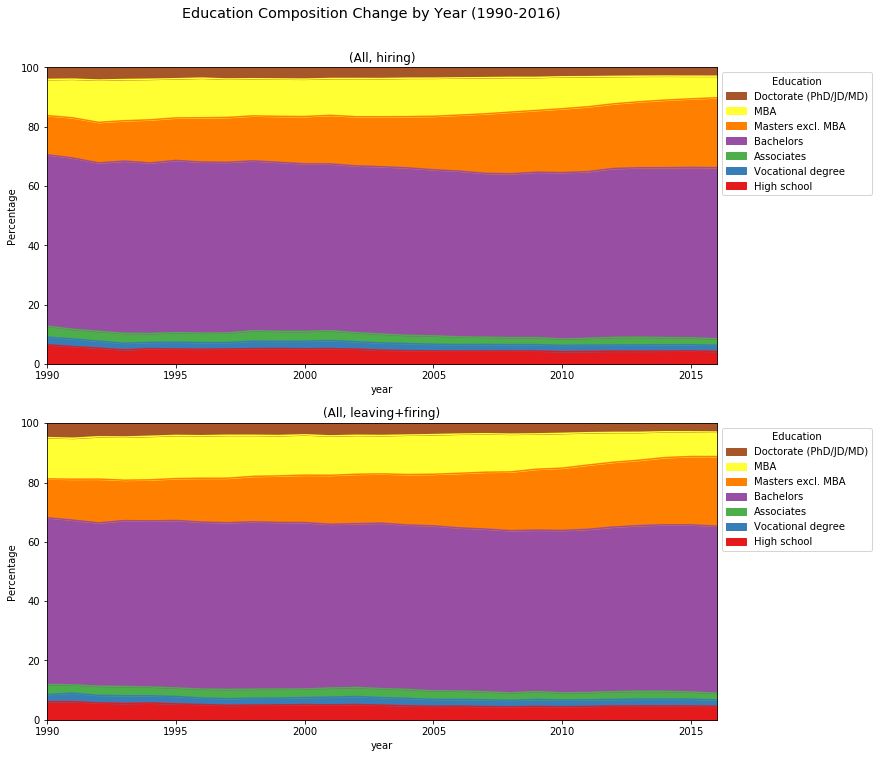

In [32]:
edu_lablst = {
    0:"None/Unknown", 1:"High school", 2:"Vocational degree", 3:"Associates", 
    4:"Bachelors", 5:"Masters excl. MBA", 6:"MBA", 7:"Doctorate (PhD/JD/MD)"
}
colormap_unif = {str(idx):clr for idx, clr in zip(
    range(len(edu_lablst)),
    itertools.cycle([plt.get_cmap('Dark2').colors[0]]+list(plt.get_cmap('Set1').colors))
)}

# Codes for showing pie charts:
# fig,axs=plt.subplots(3,2,figsize=(15,22.5))
# for (idx,col),ax in zip(empl_changes_df.loc[:].pivot_table(
#     index='edu',columns=['ticker','type'],values='gender',aggfunc='count'
# ).iteritems(),itertools.chain.from_iterable(axs)):
#     col.plot.pie(
#         ax=ax, labeldistance=1.05, title=str(idx).replace("'",''), autopct='%.2f', pctdistance=0.9,
#         colors=[colormap_unif[idx] for idx in col.index], labels=[edu_lablst[x] for x in range(0,8)]
#     )
#     ax.set_ylabel('')
# plt.show()

## Continued ##
f_none_hidden = True # Whether to show the "None/Unknown"s.

# Plot composition changes by years.
for (idx, grp), ax, xleft in zip(
    empl_changes_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016), ['ticker','type','year','edu']
    ].replace(
        to_replace={"type":{"firing":"leaving+firing","leaving":"leaving+firing"}}
    ).groupby(['ticker','type']), iterator_for_axis(
        rep_time=2,fig_func=lambda x:x.suptitle("Education Composition Change by Year (1990-2016)", fontsize='x-large', y=0.95)
    ), [x for x in xlefts for _ in range(2)]
):
    to_plot = grp.loc[lambda df:[int(x)>=f_none_hidden for x in df.edu]].assign(count = 1).pivot_table(
        index='year', columns='edu', values='count', aggfunc='sum', fill_value=0 
    ).apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        ylim=(0,100), title=str(idx).replace("'",""),
        xlim=(xleft,2016), xticks=[1990+x*5 for x in range(6)]
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), [edu_lablst[int(x)] for x in reversed(labels)], 
        loc='upper left',bbox_to_anchor=(1,1),title="Education"
    )
plt.show()



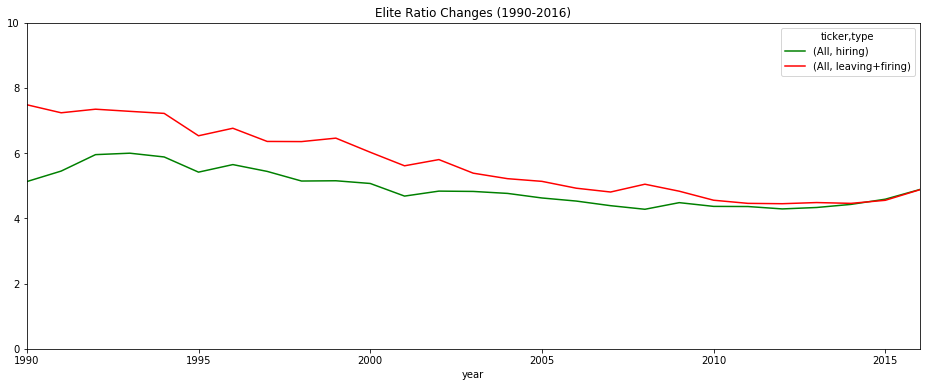

In [33]:
for (ticker, grp), xleft in zip(
    empl_changes_df.replace(
        to_replace={"type":{"firing":"leaving+firing","leaving":"leaving+firing"}}
    ).groupby('ticker'), xlefts
):
    grp.loc[lambda df:df.year>=xleft].pivot_table(
        index='year',columns=['ticker','type'],values='f_elite',
        aggfunc=lambda x:((x=='True').sum()/(x==x).sum()*100)
    ).plot(
        xlim=(1990,2016),color=color_styles,ylim=(0,10),
        title="Elite Ratio Changes (1990-2016)",figsize=(16,6)
    )
    ax.set_ylabel('Percentage')
plt.show()

# By Next Industry.

Note: Division of 2-digit NAICS's into industry groups are obtained from [Bureau of Labor Statistics](https://www.bls.gov/iag/tgs/iag_index_naics.htm).

In [34]:
NAICS2GRP_dict = {
    '11': (1, "Natural Resources and Mining"),
    '21': (1, "Natural Resources and Mining"),
    '23': (2, "Construction"),
    '31': (3, "Manufacturing"),
    '32': (3, "Manufacturing"),
    '33': (3, "Manufacturing"),
    '42': (4, "Trade, Transportation, and Utilities"),
    '44': (4, "Trade, Transportation, and Utilities"),
    '45': (4, "Trade, Transportation, and Utilities"),
    '48': (4, "Trade, Transportation, and Utilities"),
    '49': (4, "Trade, Transportation, and Utilities"),
    '22': (4, "Trade, Transportation, and Utilities"),
    '51': (5, "Information"),
    '52': (6, "Financial Activities"),
    '53': (6, "Financial Activities"),
    '54': (7, "Professional and Business Services"),
    '55': (7, "Professional and Business Services"),
    '56': (7, "Professional and Business Services"),
    '61': (8, "Education and Health Services"),
    '62': (8, "Education and Health Services"),
    '71': (9, "Leisure and Hospitality"),
    '72': (9, "Leisure and Hospitality"),
    '81': (10, "Other Services"),
    '92': (11, "Public Administration"),
    '99': (12, "Unknown/Unclassified"),
    ''  : (12, "Unknown/Unclassified"),
    'MI': (12, "Unknown/Unclassified"),
    '46': (12, "Unknown/Unclassified"),
    'GO': (12, "Unknown/Unclassified")
}

# Show the mappings.
pd.DataFrame(
    [[key, value[0], value[1]] for key,value in NAICS2GRP_dict.items()]
).groupby([1,2])[0].apply(lambda ser:', '.join(ser)).reset_index().drop(1,axis=1).rename(
    {2:"Industry group",0:"NAICS2"},axis=1
)

,Industry group,NAICS2
0,Natural Resources and Mining,"11, 21"
1,Construction,23
2,Manufacturing,"31, 32, 33"
3,"Trade, Transportation, and Utilities","42, 44, 45, 48, 49, 22"
4,Information,51
5,Financial Activities,"52, 53"
6,Professional and Business Services,"54, 55, 56"
7,Education and Health Services,"61, 62"
8,Leisure and Hospitality,"71, 72"
9,Other Services,81


Note: `46` seems to be a wrong NAICS2 code.

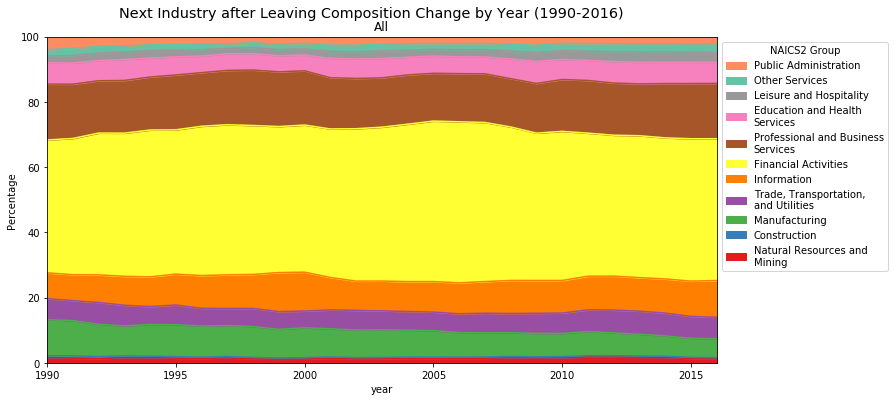

In [35]:
ind_next_lst = sorted(list(set(NAICS2GRP_dict.values())))
colormap_unif = {idx:clr for idx, clr in zip(
    ind_next_lst[:-1], # Assume the last element is "Others".
    itertools.cycle(plt.get_cmap('Set1').colors+plt.get_cmap('Set2').colors+plt.get_cmap('Set3').colors)
)}
colormap_unif[ind_next_lst[-1]] = plt.get_cmap('Dark2').colors[0]

# Codes for showing pie charts:
# fig,axs=plt.subplots(1,2,figsize=(15,7.5))
# for (idx,col),ax in zip(empl_changes_df.loc[lambda df:df.type=='leaving'].pivot_table(
#     index=empl_changes_df.ind_next.apply(lambda x:NAICS2GRP_dict[x[:2]]),
#     columns='ticker', values='gender', aggfunc='count'
# ).iteritems(),axs):
#     col.plot.pie(
#         ax=ax, labeldistance=1.05, title=str(idx).replace("'",''), autopct='%.2f', pctdistance=0.9,
#         colors=[colormap_unif[idx] for idx in col.index], labels=[x[1] for x in col.index]
#     )
#     ax.set_ylabel('')
# plt.show()

## Continued ##
f_none_hidden = True # Whether to show the "None/Unknown"s.

# Plot composition changes by years.
for (idx, grp), ax, xleft in zip(
    empl_changes_df.loc[
        lambda df:(df.year>=1990)&(df.year<=2016)&(df.type=='leaving'), ['ticker','type','year','ind_next']
    ].groupby('ticker'), iterator_for_axis(
        fig_func=lambda x:x.suptitle("Next Industry after Leaving Composition Change by Year (1990-2016)", fontsize='x-large', y=0.95)
    ), xlefts
):
    to_plot = grp.assign(count=1).pivot_table(
        columns=grp.ind_next.apply(lambda x:NAICS2GRP_dict[x[:2]]),
        index='year', values='count', aggfunc='sum', fill_value=0
    )
    if f_none_hidden:
        to_plot.drop(ind_next_lst[-1], axis=1, inplace=True)
    to_plot = to_plot.apply(lambda x:x/sum(x)*100, axis=1)
    to_plot.plot(
        kind='area', ax=ax, color=[colormap_unif[idx] for idx in to_plot.columns],
        ylim=(0,100), title=idx, xlim=(xleft,2016), xticks=[1990,1995,2000,2005,2010,2015]
    )
    ax.set_ylabel("Percentage")
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        reversed(handles), ["\n".join(wrap(re.match(r"\(\d+, (.+)\)",x).group(1),25)) for x in reversed(labels)], 
        loc='upper left', bbox_to_anchor=(1,1), title="NAICS2 Group"
    )
plt.show()

## Tenure and Number of Promotions.

Note:
- Tenure = End date of last entry - Start date of first entry in a consecutive sequence of entries in the same company;
 - When there is any invalid month in the two dates and their years are _not_ the same, the invalid month is replaced by 6;
 - When there is any invalid month in the two dates and their years are the same, the invalid month is assumed to be the extreme value (0 for start and 12 for end) and the results are the minimum of their difference and 6.
- Number of promotions = Number of entries in a consecutive sequence of entries in the same company - 1.

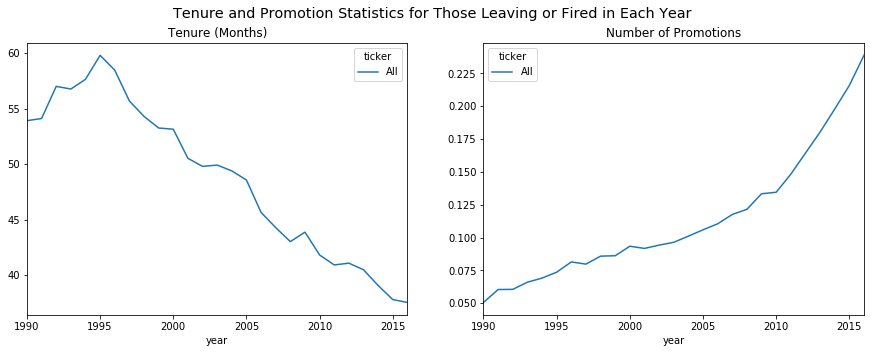

In [36]:
for (ticker, grp), xleft in zip(empl_changes_df.groupby('ticker'),xlefts):
    # Calculate.
    to_plot = grp.loc[lambda df:(df.type!='hiring')&(df.year>=xleft)&(df.year<=2016)].astype(
        {'tenure':'Int64','nprom':'Int64'}
    ).pivot_table(
        columns=['ticker'],index='year',values=['tenure','nprom'],aggfunc=np.nanmean
    )

    # Plot.
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
    fig.suptitle("Tenure and Promotion Statistics for Those Leaving or Fired in Each Year",fontsize='x-large')
    to_plot['tenure'].plot(
        title="Tenure (Months)",ax=ax1,xticks=[1990,1995,2000,2005,2010,2015],xlim=(xleft,2016)
    )
    to_plot['nprom'].plot(
        title="Number of Promotions",ax=ax2,xticks=[1990,1995,2000,2005,2010,2015],xlim=(xleft,2016)
    )
plt.show()